In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy import stats
from astropy.io import fits

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
from glob import glob
import math


In [2]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [3]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [4]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')

am.xants = []


In [5]:

v = deepcopy(uv)


In [6]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))


In [7]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)


In [8]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 2.*np.pi / B
    
    tau = dist / c
    
    temp = np.zeros((60,1024,4))
    
    T = uv.Ntimes*10
    
    del_nu = 2.*np.pi / T
    
    earth_rot = 2*np.pi / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    for i in range(uv.Ntimes/2):
        
        for j in range(int(math.ceil(float(tau/del_tau)))):
            
            temp[i][j][0]= np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
            if (i != 0):
            
                temp[-i][j][0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
    result = np.fft.fftn(temp)
    
    return result


In [9]:

nu_rang = np.zeros((60,1024,4))
    
tau_rang = np.zeros((60,1024,4))
    
for i in range(uv.Ntimes):
        
    nu_rang[i,:,:] = -i
        
for j in range(uv.Nfreqs/2 + 1):
        
    tau_rang[:,j,:] = j
    
    if (j != 0):
        
        tau_rang[:,-j,:] = j
  

In [10]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = uv.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 1. / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.random.normal(amp,width,(60,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau)
    
    result = np.fft.fftn(temp)
    
    return result
    

In [11]:

def noise(amp,width):
    
    result = np.random.normal(amp,width,(60,1024,4))
    
    return result


In [12]:

ants = uv.antenna_numbers

ant_delay = {}

for i in ants:
    
    ant_delay[i] = np.random.normal(0,2e-7)
    #ant_delay[i] = np.random.randint(10)
    

In [13]:

def generate_random_data(i_width,x_width):
    
    new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)
    
    s_amp = 0
    
    s_width = 1
    
    i_amp = 0
    
    n_amp = 0
    
    n_width = 0.1
    
    xant = 23

    x_amp = 0
    
    snr = 10
    
    for i in reds:
        
        sig = signal(s_amp,s_width,i[0])
        
        for j in i:
            
            sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            indices = v.antpair2ind(j[0],j[1])
        
            i_sig = signal(i_amp,i_width,j)
            
            i_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            if ((j[0] == xant) or (j[1] == xant)):
            
                x_sig = signal(x_amp,x_width,j)
            
                x_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
                norm_power = float(s_width**2)
            
                new_power = float(norm_power + i_width**2 + x_width**2)
            
                ratio = np.sqrt(norm_power/new_power)
            
                sigs = (sig + i_sig + x_sig) * ratio
            
            else:
            
                norm_power = float(s_width**2)
            
                new_power = float(norm_power + i_width**2)
            
                ratio = np.sqrt(norm_power/new_power)
            
                sigs = (sig + i_sig) * ratio
            
            noi = noise(n_amp,n_width)
        
            noi_power = np.mean(np.abs(noi))
        
            sig_power = np.mean(np.abs(sigs))
        
            noi_mod = snr/(sig_power/noi_power)
        
            noi /= noi_mod
            
            visibility = sigs + noi
            
            new_data_array[indices,0,:,:] = visibility
            
            
    for k in nonreds:
        
        sig = signal(s_amp,s_width,k)
        
        i_sig = signal(i_amp,i_width,j)
        
        norm_power = float(s_width**2)
        
        new_power = float(norm_power + i_width**2)
        
        ratio = np.sqrt(norm_power/new_power)
        
        sigs = (sig + i_sig) * ratio
        
        indices = v.antpair2ind(k[0],k[1])
        
        noi = noise(n_amp,n_width)
        
        noi_power = np.mean(np.abs(noi))
        
        sig_power = np.mean(np.abs(sigs))
        
        noi_mod = snr/(sig_power/noi_power)
        
        noi /= noi_mod
        
        visibility = sig
        
        new_data_array[indices,0,:,:] = visibility
        
        return new_data_array


In [14]:

def new_compute_median_auto_power_dict(data, pols, reds):
    
    autoPower = {}
    for pol in pols:
        for bls in reds:
            for (i, j) in bls:
                autoPower[i, j, pol] = np.median(np.mean(np.abs(data.get_data(i, j, pol))**2, axis=1))
    return autoPower


In [15]:
def new_red_corr_metrics(data, pols, antpols, ants, reds, xants=[], rawMetric=False, crossPol=False):

    # Compute power correlations and assign them to each antenna
    autoPower = new_compute_median_auto_power_dict(data, pols, reds)
    antCorrs = {(ant, antpol): 0.0 for ant in ants for antpol in antpols if
                (ant, antpol) not in xants}
    antCounts = deepcopy(antCorrs)
    for pol0 in pols:
        for pol1 in pols:
            iscrossed_i = (pol0[0] != pol1[0])
            iscrossed_j = (pol0[1] != pol1[1])
            onlyOnePolCrossed = (iscrossed_i ^ iscrossed_j)
            # This function can instead record correlations for antennas whose counterpart are pol-swapped
            if (not crossPol and (pol0 is pol1)) or (crossPol and onlyOnePolCrossed):
                for bls in reds:
                    for n, (ant0_i, ant0_j) in enumerate(bls):
                        data0 = data.get_data(ant0_i, ant0_j, pol0)
                        for (ant1_i, ant1_j) in bls[n + 1:]:
                            data1 = data.get_data(ant1_i, ant1_j, pol1)
                            corr = np.median(np.mean(np.abs(data0) * np.abs(data1),axis=1))
                            
                            corr /= np.sqrt(autoPower[ant0_i, ant0_j, pol0] *
                                            autoPower[ant1_i, ant1_j, pol1])
                            antsInvolved = [(ant0_i, pol0[0]), (ant0_j, pol0[1]),
                                            (ant1_i, pol1[0]), (ant1_j, pol1[1])]
                            if not np.any([(ant, antpol) in xants for ant, antpol
                                           in antsInvolved]):
                                # Only record the crossed antenna if i or j is crossed
                                if crossPol and iscrossed_i:
                                    antsInvolved = [(ant0_i, pol0[0]),
                                                    (ant1_i, pol1[0])]
                                elif crossPol and iscrossed_j:
                                    antsInvolved = [(ant0_j, pol0[1]), (ant1_j, pol1[1])]
                                for ant, antpol in antsInvolved:
                                    antCorrs[(ant, antpol)] += corr
                                    antCounts[(ant, antpol)] += 1

    # Compute average and return
    for key, count in antCounts.items():
        if count > 0:
            antCorrs[key] /= count
        else:
            # Was not found in reds, should not have a valid metric.
            antCorrs[key] = np.NaN
    if rawMetric:
        return antCorrs
    else:
        return per_antenna_modified_z_scores(antCorrs)


In [16]:

def generate_random_array(width_array):
    
    new_array = list(np.zeros((10,10,3)))
    
    for i in range(len(width_array)):
        
        print 'i: ' + str(i)
        
        for j in range(len(width_array[i])):
            
            print 'j: ' + str(j)
            
            i_width = float(width_array[i][j][0])
            
            n_width = float(width_array[i][j][1])
            
            temp_array = generate_random_data(i_width,n_width)
            
            v.data_array = temp_array
            
            am.data.data_array = temp_array
            
            rawRed = new_red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)
            
            z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)
            
            a = z_scores[(23,'x')]
            
            b = z_scores[(23,'y')]
            
            values_raw = []

            for key in z_scores.keys():
                
                values_raw.append(rawRed[key])
                
            c = np.array(values_raw).mean()
            
            new_array[i][j][0] = a
            
            new_array[i][j][1] = b
            
            new_array[i][j][2] = c

            
    return new_array
            
            
    


In [17]:

input_array = []

for i in range(10):
    
    input_array.append([])
    
    for j in range(10):
        
        input_array[i].append([])


In [18]:

i_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]

x_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]


In [19]:

for i in range(10):
    
    for j in range(10):
        
        input_array[i][j] = (i_vals[i],x_vals[j])


In [20]:
print input_array

[[(0, 0), (0, 0.25), (0, 0.5), (0, 0.75), (0, 1.0), (0, 1.25), (0, 1.5), (0, 2.0), (0, 3.0), (0, 4.0)], [(0.25, 0), (0.25, 0.25), (0.25, 0.5), (0.25, 0.75), (0.25, 1.0), (0.25, 1.25), (0.25, 1.5), (0.25, 2.0), (0.25, 3.0), (0.25, 4.0)], [(0.5, 0), (0.5, 0.25), (0.5, 0.5), (0.5, 0.75), (0.5, 1.0), (0.5, 1.25), (0.5, 1.5), (0.5, 2.0), (0.5, 3.0), (0.5, 4.0)], [(0.75, 0), (0.75, 0.25), (0.75, 0.5), (0.75, 0.75), (0.75, 1.0), (0.75, 1.25), (0.75, 1.5), (0.75, 2.0), (0.75, 3.0), (0.75, 4.0)], [(1.0, 0), (1.0, 0.25), (1.0, 0.5), (1.0, 0.75), (1.0, 1.0), (1.0, 1.25), (1.0, 1.5), (1.0, 2.0), (1.0, 3.0), (1.0, 4.0)], [(1.25, 0), (1.25, 0.25), (1.25, 0.5), (1.25, 0.75), (1.25, 1.0), (1.25, 1.25), (1.25, 1.5), (1.25, 2.0), (1.25, 3.0), (1.25, 4.0)], [(1.5, 0), (1.5, 0.25), (1.5, 0.5), (1.5, 0.75), (1.5, 1.0), (1.5, 1.25), (1.5, 1.5), (1.5, 2.0), (1.5, 3.0), (1.5, 4.0)], [(2.0, 0), (2.0, 0.25), (2.0, 0.5), (2.0, 0.75), (2.0, 1.0), (2.0, 1.25), (2.0, 1.5), (2.0, 2.0), (2.0, 3.0), (2.0, 4.0)], [(3.0

In [21]:

#holder_array_mkjames_zscore = generate_random_array(input_array)

#np.savez('holder_array_mkjames_zscore.npz',holder_array_mkjames_zscore)


In [22]:

data = np.load('holder_array_mkjames_zscore.npz')

holder_array = data['arr_0']

#holder_array = holder_array_mkjames_zscore


In [23]:
print holder_array

[[[ -1.38780566e+00   2.52949589e+00   9.93493555e-01]
  [ -5.75330899e+01  -5.87935439e+01   9.92451872e-01]
  [ -6.44772361e+01  -6.20479993e+01   9.89397856e-01]
  [ -8.25598124e+01  -1.07737383e+02   9.86847784e-01]
  [ -9.68120474e+01  -7.96320777e+01   9.84955722e-01]
  [ -6.67787342e+01  -8.66039790e+01   9.82961085e-01]
  [ -9.14321137e+01  -8.42588589e+01   9.81973168e-01]
  [ -7.94904078e+01  -8.12085303e+01   9.80770627e-01]
  [ -1.10358067e+02  -9.75188929e+01   9.78867113e-01]
  [ -1.23531021e+02  -9.42482491e+01   9.78297419e-01]]

 [[ -5.27030811e-01  -3.71873419e-01   9.66670837e-01]
  [ -9.46057630e+00  -9.87055934e+00   9.63347174e-01]
  [ -3.46326112e+01  -2.59067949e+01   9.63474537e-01]
  [ -5.40898583e+01  -5.69460949e+01   9.60884546e-01]
  [ -4.83651370e+01  -5.75146306e+01   9.57761840e-01]
  [ -6.17384612e+01  -8.02041625e+01   9.56711942e-01]
  [ -7.05693188e+01  -7.30115041e+01   9.55947169e-01]
  [ -4.90897992e+01  -7.68712577e+01   9.51858307e-01]
  [ -6.0

In [24]:
print holder_array[0][0][1] 

2.52949589379


In [25]:
#holder_array[0][0][0] = 0.
#holder_array[0][0][1] = 0


print holder_array

[[[ -1.38780566e+00   2.52949589e+00   9.93493555e-01]
  [ -5.75330899e+01  -5.87935439e+01   9.92451872e-01]
  [ -6.44772361e+01  -6.20479993e+01   9.89397856e-01]
  [ -8.25598124e+01  -1.07737383e+02   9.86847784e-01]
  [ -9.68120474e+01  -7.96320777e+01   9.84955722e-01]
  [ -6.67787342e+01  -8.66039790e+01   9.82961085e-01]
  [ -9.14321137e+01  -8.42588589e+01   9.81973168e-01]
  [ -7.94904078e+01  -8.12085303e+01   9.80770627e-01]
  [ -1.10358067e+02  -9.75188929e+01   9.78867113e-01]
  [ -1.23531021e+02  -9.42482491e+01   9.78297419e-01]]

 [[ -5.27030811e-01  -3.71873419e-01   9.66670837e-01]
  [ -9.46057630e+00  -9.87055934e+00   9.63347174e-01]
  [ -3.46326112e+01  -2.59067949e+01   9.63474537e-01]
  [ -5.40898583e+01  -5.69460949e+01   9.60884546e-01]
  [ -4.83651370e+01  -5.75146306e+01   9.57761840e-01]
  [ -6.17384612e+01  -8.02041625e+01   9.56711942e-01]
  [ -7.05693188e+01  -7.30115041e+01   9.55947169e-01]
  [ -4.90897992e+01  -7.68712577e+01   9.51858307e-01]
  [ -6.0

In [26]:
array_1 = []

for i in range(10):
    
    array_1.append([])
    
    for j in range(10):
        
        array_1[i].append(holder_array[i][j][0])
        
print array_1

[[-1.3878056628465556, -57.533089904321116, -64.477236079941662, -82.559812376850175, -96.812047436709847, -66.778734210184922, -91.43211372244977, -79.490407781354151, -110.35806749180571, -123.53102071787342], [-0.52703081051719936, -9.4605762953226868, -34.632611222374059, -54.089858349495202, -48.365137031247045, -61.738461242562401, -70.569318760714111, -49.0897992382233, -60.937640579305778, -68.771223698506077], [0.8576603390994938, -4.0856275831129123, -8.3926860918003747, -21.489537979140671, -17.662517336842466, -32.582030472258118, -33.658286455210884, -24.386820425453593, -34.54427164898101, -35.110640041773514], [-0.35371890926718258, -2.2010839434401301, -3.2548852710883907, -6.174712747002344, -11.183080497592581, -14.948276816256644, -18.182817673382267, -24.132092129490566, -26.441910251335777, -25.745941249965234], [1.3191717430226104, 0.75477093481655066, -1.9820327603414305, -5.2351240016364207, -6.9233461545472519, -6.0880092820811882, -6.8475896575413495, -10.4989

In [27]:
array_2 = []

for i in range(10):
    
    array_2.append([])
    
    for j in range(10):
        
        array_2[i].append(holder_array[i][j][1])
        
print array_2

[[2.5294958937902368, -58.793543864039982, -62.047999260521955, -107.73738345601393, -79.632077651284405, -86.603978984000804, -84.258858893495045, -81.208530281308825, -97.518892863768954, -94.248249145706083], [-0.37187341865133072, -9.8705593448747457, -25.9067948688384, -56.946094945180398, -57.514630611308881, -80.20416246630505, -73.01150411366487, -76.871257733545121, -98.320682905449942, -117.02279254751173], [-0.071878527492745786, -5.5936203112907235, -15.189244390177358, -19.321449523413499, -20.150010936158367, -31.932662793510694, -30.084514288206805, -44.782543740188608, -55.948447164375217, -47.229032551694502], [0.2497582666239796, -2.9344759550143755, -2.930307257210746, -7.0694376978196436, -9.2228244527616745, -15.106247509106556, -15.116099283257348, -16.01921671226776, -39.255768451706494, -27.501340091531919], [-1.6328631927335588, -0.84432948314880607, -2.1332407103267554, -4.8848865021084311, -4.3473953917172441, -5.843518620992441, -9.2151793199175724, -11.9247

In [28]:
array_3 = []

for i in range(10):
    
    array_3.append([])
    
    for j in range(10):
        
        array_3[i].append(holder_array[i][j][2])
        
print array_3

[[0.99349355534149675, 0.99245187236129495, 0.98939785571508421, 0.98684778435870546, 0.98495572161476197, 0.98296108520527781, 0.98197316768649645, 0.98077062694738182, 0.97886711306940144, 0.97829741936798964], [0.96667083694870293, 0.96334717397551384, 0.96347453724174525, 0.96088454625305897, 0.95776184044548163, 0.95671194197528908, 0.95594716948167913, 0.95185830740302857, 0.95315840776518757, 0.95409932118210938], [0.91108629273759223, 0.91003764710512525, 0.91296167450375321, 0.91219757282121683, 0.90685222157055079, 0.90862435635202521, 0.9047889081221665, 0.90518110371094151, 0.90684150156330778, 0.90416452422218763], [0.86417475872361349, 0.87221046620087239, 0.86862296077821599, 0.86570196046393688, 0.86451188939253865, 0.8642436427750636, 0.86746249834435329, 0.86226302706620161, 0.86514565189925097, 0.8637075979557427], [0.83935696367641632, 0.83894975994138898, 0.8402781201670092, 0.83807964101741694, 0.83881758114310645, 0.84057381273654808, 0.83646851619756346, 0.83558

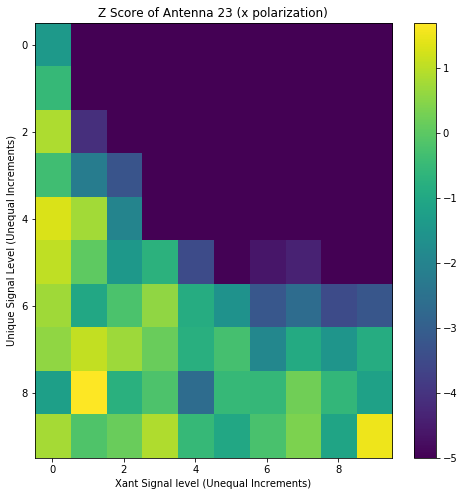

In [29]:

plt.figure(figsize=(8,8))
plt.imshow(array_1,aspect='auto', vmin = -5)
plt.title('Z Score of Antenna 23 (x polarization)')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


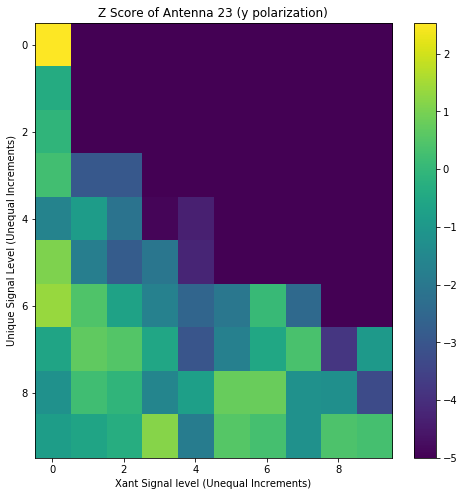

In [30]:

plt.figure(figsize=(8,8))
plt.imshow(array_2,aspect='auto',vmin = -5)
plt.title('Z Score of Antenna 23 (y polarization)')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [42]:

avg_array = np.zeros((10,10))

for i in range(len(array_1)):
    
    for j in range(len(array_1[0])):
        
        avg_array[i,j] = (array_1[i][j]+array_2[i][j])/2.
        

[[  5.70845115e-01  -5.81633169e+01  -6.32626177e+01  -9.51485979e+01
   -8.82220625e+01  -7.66913566e+01  -8.78454863e+01  -8.03494690e+01
   -1.03938480e+02  -1.08889635e+02]
 [ -4.49452115e-01  -9.66556782e+00  -3.02697030e+01  -5.55179766e+01
   -5.29398838e+01  -7.09713119e+01  -7.17904114e+01  -6.29805285e+01
   -7.96291617e+01  -9.28970081e+01]
 [  3.92890906e-01  -4.83962395e+00  -1.17909652e+01  -2.04054938e+01
   -1.89062641e+01  -3.22573466e+01  -3.18714004e+01  -3.45846821e+01
   -4.52463594e+01  -4.11698363e+01]
 [ -5.19803213e-02  -2.56777995e+00  -3.09259626e+00  -6.62207522e+00
   -1.02029525e+01  -1.50272622e+01  -1.66494585e+01  -2.00756544e+01
   -3.28488394e+01  -2.66236407e+01]
 [ -1.56845725e-01  -4.47792742e-02  -2.05763674e+00  -5.06000525e+00
   -5.63537077e+00  -5.96576395e+00  -8.03138449e+00  -1.12118536e+01
   -1.70038629e+01  -1.66319124e+01]
 [  1.06839166e+00  -8.73013806e-01  -2.12673659e+00  -1.37332472e+00
   -3.84199894e+00  -6.48551643e+00  -7.04820

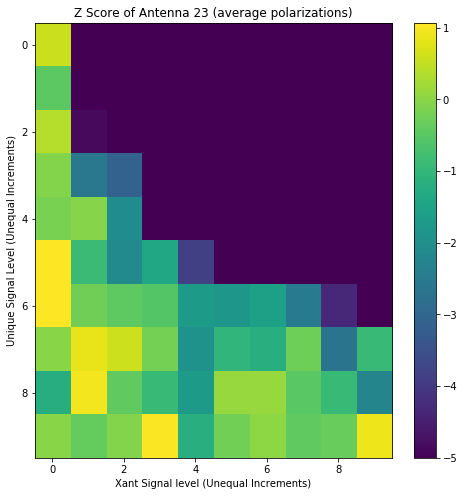

In [43]:

plt.figure(figsize=(8,8))
plt.imshow(avg_array,aspect='auto', vmin = -5)
plt.title('Z Score of Antenna 23 (average polarizations)')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


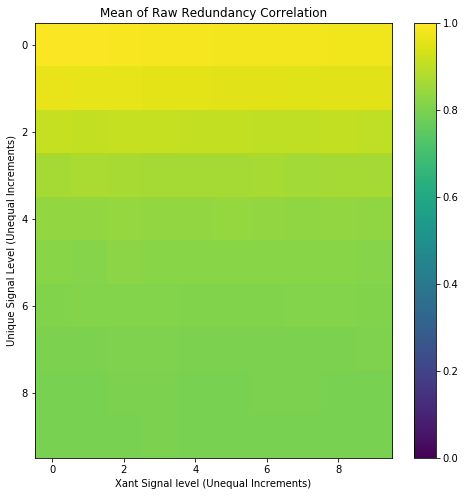

In [31]:

plt.figure(figsize=(8,8))
#plt.imshow(array_3,aspect='auto')
plt.imshow(array_3,aspect='auto',vmax = 1, vmin = 0)
plt.title('Mean of Raw Redundancy Correlation')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [32]:

slice_0 = []
slice_1 = []
slice_2 = []
slice_3 = []
slice_4 = []
slice_5 = []


for i in range(len(holder_array)):
    
    slice_0.append(holder_array[0][i][0])
    slice_1.append(holder_array[1][i][0])
    slice_2.append(holder_array[2][i][0])
    slice_3.append(holder_array[3][i][0])
    slice_4.append(holder_array[4][i][0])
    slice_5.append(holder_array[5][i][0])
    

In [45]:

avg_0 = []
avg_1 = []
avg_2 = []
avg_3 = []
avg_4 = []
avg_5 = []


for i in range(len(avg_array)):
    
    avg_0.append(avg_array[0][i])
    avg_1.append(avg_array[1][i])
    avg_2.append(avg_array[2][i])
    avg_3.append(avg_array[3][i])
    avg_4.append(avg_array[4][i])
    avg_5.append(avg_array[5][i])
    

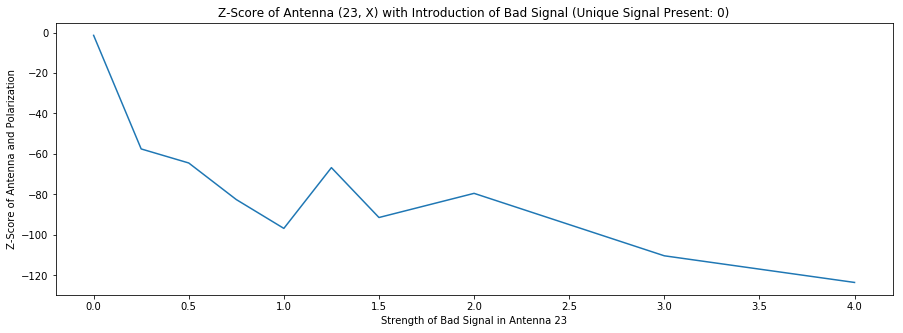

In [33]:

plt.figure(figsize = (15,5))
plt.plot(x_vals,slice_0)
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal (Unique Signal Present: 0)')
plt.show()


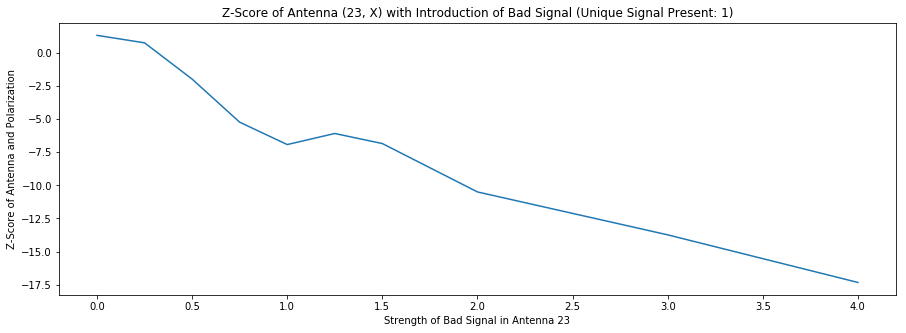

In [34]:

plt.figure(figsize = (15,5))
plt.plot(x_vals,slice_4)
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal (Unique Signal Present: 1)')
plt.show()


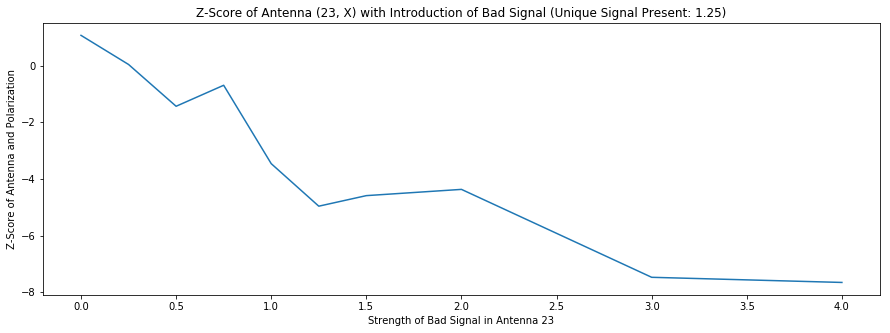

In [35]:

plt.figure(figsize = (15,5))
plt.plot(x_vals,slice_5)
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal (Unique Signal Present: 1.25)')
plt.show()


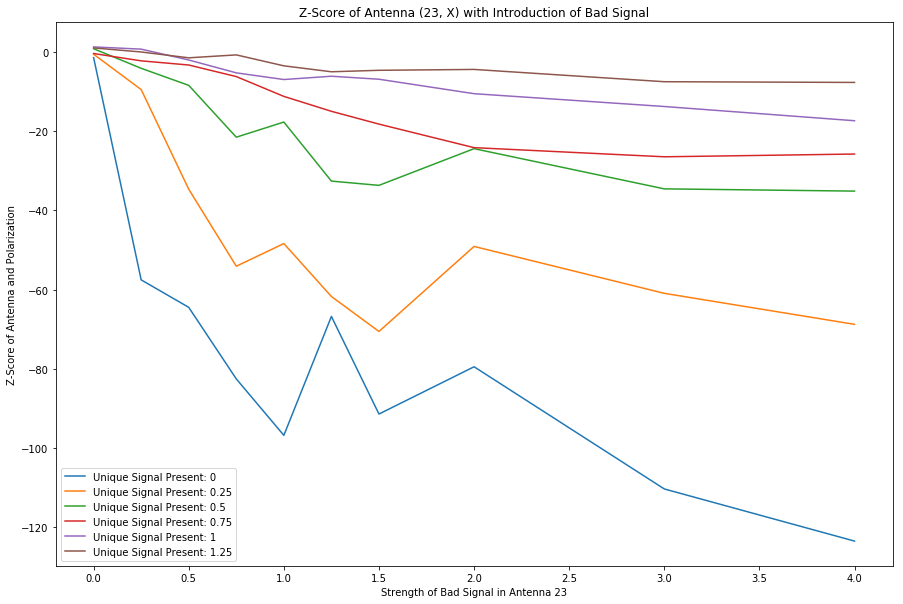

In [36]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,slice_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,slice_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,slice_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,slice_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,slice_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,slice_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal')
plt.legend()
plt.show()


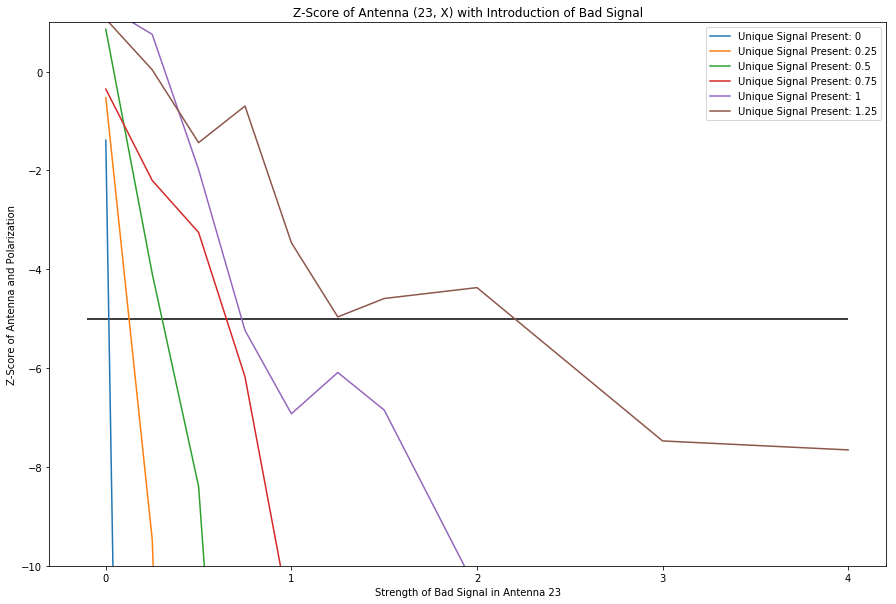

In [37]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,slice_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,slice_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,slice_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,slice_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,slice_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,slice_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal')
plt.hlines(-5,-0.1,4)
plt.ylim((-10,1))
plt.legend()
plt.show()


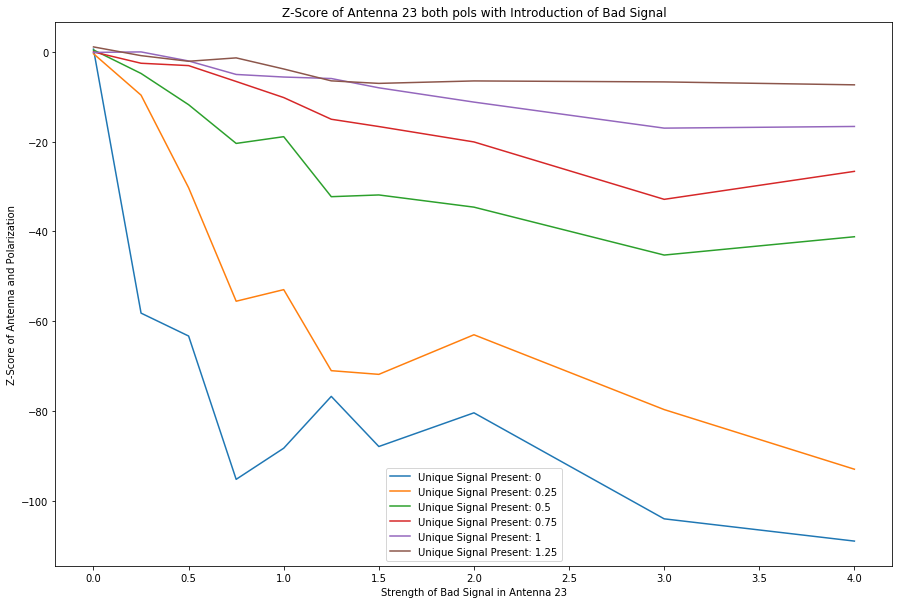

In [46]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,avg_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,avg_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,avg_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,avg_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,avg_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,avg_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna 23 both pols with Introduction of Bad Signal')
plt.legend()
plt.show()


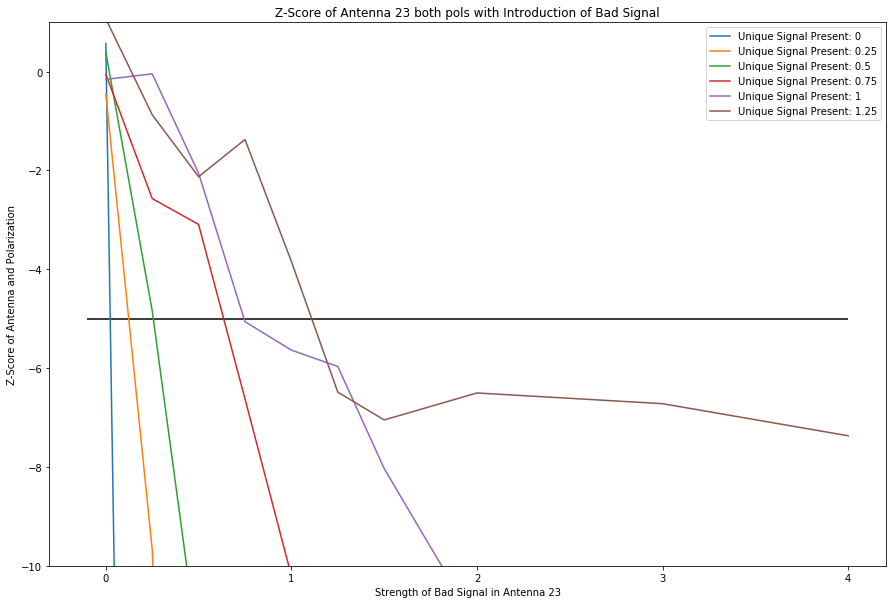

In [48]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,avg_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,avg_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,avg_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,avg_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,avg_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,avg_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna 23 both pols with Introduction of Bad Signal')
plt.hlines(-5,-0.1,4)
plt.ylim((-10,1))
plt.legend()
plt.show()


In [ ]:

#SEFD (System Equivalent Flux Density)

#Possible SNR Values:

#Set 1
#380
#290
#417
#320

#Set 2
#875

#Set 3
#530
#866
#195
#320

#Average:
#466
